In [36]:
import torch
import numpy as np
import random

def make_determenistic_or_random(seed):
    """
    based on seed makes everything random or determenistic. Any other than None are for determenistic
    """
    # I still need to keep in mind sklearn random_state
    random.seed(seed)
    torch.manual_seed(seed if seed != None else torch.seed())
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed if seed != None else torch.seed())
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True if seed!=None else False
    torch.backends.cudnn.benchmark = False if seed!=None else True

make_determenistic_or_random(0)

In [37]:
import pandas as pd
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
import os
from skimage.io import imread, imsave
from skimage.color import rgb2gray, rgba2rgb
import pytorch_lightning as pl

# data preparation

In [38]:
ds_root = '/home/alexander/work/hackathon/chest-14/images/'

In [39]:
test_img = imread("/home/alexander/work/hackathon/DATASET_MED/2000000.png")
print(test_img.dtype, test_img.min(), test_img.max())

uint8 0 252


In [40]:
test_img = imread('/mercurySOFS/Medical/NIH/images/00000001_000.png')
print(test_img.dtype, test_img.min(), test_img.max())

uint8 0 255


In [41]:
df_only_labels = pd.read_csv('/home/alexander/work/hackathon/chest-14/Data_Entry_2017.csv')
df_only_labels

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143
...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168


extracting all possible pathologies from dataset labels

In [42]:
'asd'.split('|')

['asd']

In [43]:
from functools import reduce 
pathologies = sorted(list(reduce(lambda acc, str: set(str.split('|')).union(set(acc)),df_only_labels['Finding Labels'].unique(), set([]))))
del pathologies[-5]
pathologies

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

check how to predict labels

In [44]:
labels = []
for pathology in pathologies:
    labels.append(df_only_labels['Finding Labels'].str.contains(pathology).values)

labels = np.asarray(labels).T
labels = labels.astype(int)

labels

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [45]:
# new_df = pd.DataFrame(columns=['Name',
#                                'Atelectasis',
#                                  'Cardiomegaly',
#                                  'Consolidation',
#                                  'Edema',
#                                  'Effusion',
#                                  'Emphysema',
#                                  'Fibrosis',
#                                  'Hernia',
#                                  'Infiltration',
#                                  'Mass',
#                                  'Nodule',
#                                  'Pleural_Thickening',
#                                  'Pneumonia',
#                                  'Pneumothorax'])

# new_df['Name'] = df_only_labels[0]
# for i, item in enumerate(pathologies):
#     new_df[item]=labels[:,i]

# new_df.reset_index(drop=True).to_csv('labels.csv', index=False)

In [46]:
labels[-1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Creating model with pre-trained weights

lets create a dataset class so that we can load it to dataloader

In [47]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, csv, path_to_root, pathologies, aug = None):
        super(Dataset, self).__init__()
        
        self.path_to_root = path_to_root
        self.csv = csv
        self.pathologies = pathologies
        self.aug = aug
        
        self.labels = []
        for pathology in self.pathologies:
            self.labels.append(self.csv['Finding Labels'].str.contains(pathology).values)
            
        self.labels = np.asarray(self.labels).T
        self.labels = self.labels.astype(np.float32)
        
    def __getitem__(self, idx):
        item = self.csv.iloc[idx]
        
        img = imread(os.path.join(self.path_to_root,item['Image Index']))
        if img.ndim==3:
            img = rgb2gray(img)
        img = np.expand_dims(img,-1)
        label = self.labels[idx]
        
        if self.aug:
            img = self.aug(image=img)['image']
            
        sample = {"image": img, 'label': label}
            
        return sample
    
    def __len__(self):
        return len(self.csv)

uint8 255 0
uint8 254 0
uint8 255 3
uint8 252 0
uint8 255 0
uint8 255 6
uint8 255 0
uint8 255 0
uint8 255 0
uint8 255 0
uint8 248 0
uint8 247 0
float64 1.0 0.0
uint8 255 0
uint8 255 0
uint8 255 0
uint8 249 0
uint8 251 0
uint8 251 0
uint8 249 0
uint8 255 0
uint8 255 0
uint8 255 0
uint8 246 9
uint8 252 0


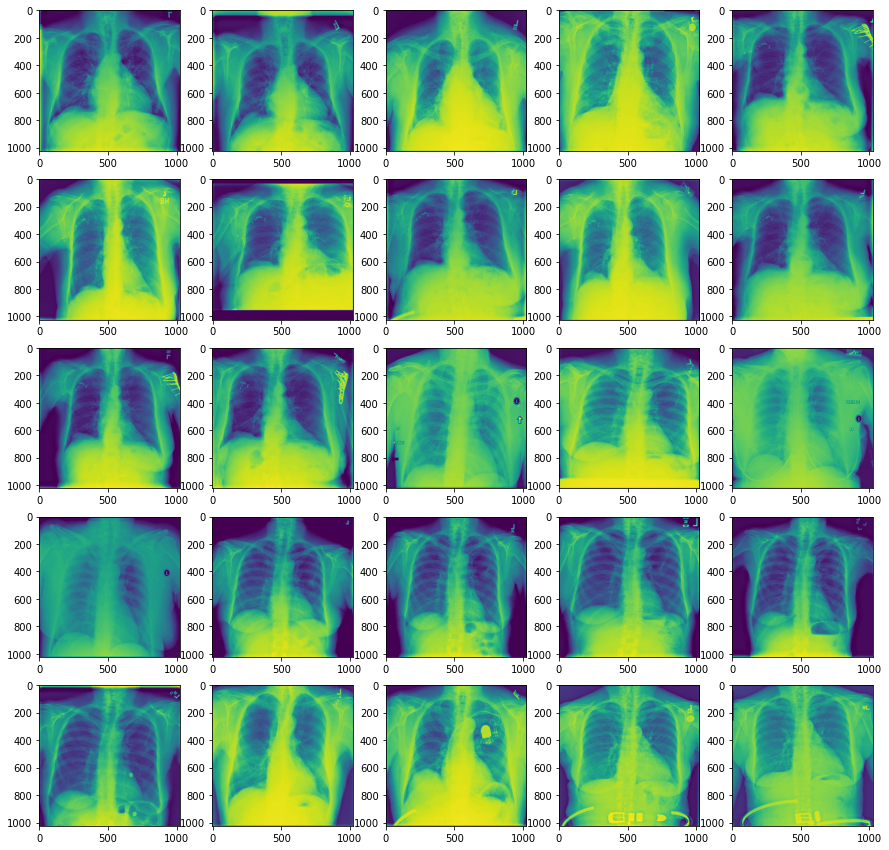

In [48]:
ds = MyDataset(df_only_labels, ds_root, pathologies = pathologies)

rows = 5
cols = 5

fig = plt.figure(figsize=(rows*3, cols*3))
for i in range(rows*cols):
    fig.add_subplot(rows,cols,i+1)
    img = ds[i]['image']
    print(img.dtype, img.max(), img.min())
    plt.imshow(img)
plt.show()

In [49]:
ds.labels.shape

(112120, 14)

In [50]:
from albumentations.core.composition import *
from albumentations.pytorch import ToTensor, ToTensorV2
from albumentations.augmentations.transforms import *

def normalizer(img, **params):
    img = img.astype(np.float32)
    if img.max()>255:
        img/=65535.
    elif img.max()>1:
        img/=255.
    return (img-0.5)*2048
        

def center_crop(img, **params):
        x,y,_ = img.shape
        crop_size = np.min([y,x])
        startx = x // 2 - (crop_size // 2)
        starty = y // 2 - (crop_size // 2)
        return img[startx:startx + crop_size, starty:starty + crop_size, :]


tr = Compose([Lambda(image=normalizer), Lambda(image=center_crop), Resize(224, 224), ToTensorV2()])

In [51]:
ds = MyDataset(df_only_labels, ds_root, pathologies = pathologies, aug = tr)
ds[0]

{'image': tensor([[[  531.2180,   473.9739,   372.4344,  ...,  -983.8431,
            -983.8431,  -989.0062],
          [  447.5851,   359.6089,   -64.8246,  ...,  -986.5066,
            -983.8431,  -989.0062],
          [  305.8478,   -69.0452,  -563.7942,  ...,  -991.3008,
            -983.8431,  -989.0062],
          ...,
          [ 1023.0985,   837.8853,   452.5433,  ..., -1023.4673,
           -1024.0000, -1024.0000],
          [ 1021.1317,   836.5330,   469.5075,  ...,  -991.4647,
           -1024.0000, -1024.0000],
          [ 1022.6478,   838.7048,   458.2390,  ...,  -922.1327,
           -1024.0000, -1024.0000]]]),
 'label': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32)}

In [52]:
from sklearn.model_selection import train_test_split

train,val = train_test_split(df_only_labels, stratify=(df_only_labels['Finding Labels']=='No Finding').values, test_size=0.3)

In [53]:
train

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
49247,00012490_000.png,No Finding,0,12490,51,M,PA,2500,2048,0.168,0.168
76561,00018816_000.png,Atelectasis|Fibrosis|Infiltration|Mass,0,18816,41,M,PA,2854,2991,0.143,0.143
94015,00023816_000.png,No Finding,0,23816,28,M,PA,2726,2783,0.143,0.143
6189,00001678_004.png,No Finding,4,1678,53,M,PA,2992,2991,0.143,0.143
93616,00023517_000.png,No Finding,0,23517,33,M,PA,2048,2500,0.168,0.168
...,...,...,...,...,...,...,...,...,...,...,...
104304,00027870_000.png,No Finding,0,27870,64,F,AP,2544,3056,0.139,0.139
21747,00005772_003.png,No Finding,3,5772,61,M,PA,2992,2991,0.143,0.143
22481,00005963_002.png,No Finding,2,5963,22,M,AP,2500,2048,0.171,0.171
20536,00005499_001.png,No Finding,1,5499,82,M,AP,2500,2048,0.171,0.171


In [54]:
train_ds = MyDataset(train, ds_root, pathologies = pathologies, aug = tr)
train_ds[0]

{'image': tensor([[[-900.4562, -920.7395, -935.6549,  ..., -951.7177, -937.9086,
           -898.3664],
          [-910.4544, -935.6549, -943.6863,  ..., -959.3802, -944.7107,
           -900.8250],
          [-917.8712, -938.5233, -951.7177,  ..., -967.2067, -951.3489,
           -924.0586],
          ...,
          [ 370.9593,  398.1266,  430.9487,  ..., -870.2566, -825.1416,
           -695.1645],
          [ 635.1341,  617.9650,  626.4471,  ..., -788.4268, -696.4348,
           -500.8954],
          [ 801.6212,  785.9681,  787.3204,  ..., -626.5700, -459.5092,
           -182.5908]]]),
 'label': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32)}

In [55]:
val_ds = MyDataset(val, ds_root, pathologies = pathologies, aug = tr)
val_ds[0]

{'image': tensor([[[-1015.9686, -1015.9686, -1015.9686,  ...,  -999.9059,
            -994.1282,  -990.1535],
          [-1015.9686, -1015.9686, -1015.9686,  ...,  -999.9059,
            -999.9059,  -991.8745],
          [-1015.9686, -1015.9686, -1015.9686,  ...,  -999.9059,
            -999.9059,  -998.1849],
          ...,
          [  -75.7244,  -341.8660,  -344.7753,  ..., -1015.9686,
           -1015.9686, -1015.9686],
          [ -145.8350,  -483.8492,  -364.4850,  ..., -1015.9686,
           -1015.9686, -1015.9686],
          [ -283.4337,  -502.5344,  -371.0412,  ..., -1015.9686,
           -1015.9686, -1015.9686]]]),
 'label': array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       dtype=float32)}

# model part

In [56]:
import torchxrayvision as xrv
model = xrv.models.DenseNet(weights="nih")

class NewModel(torch.nn.Module):
    def __init__(self, xrayvisionmodel):
        super(NewModel, self).__init__()
        
        self.encoder = xrayvisionmodel.features
        self.ln = torch.nn.Linear(1024, 14)
        
    def forward(self,x):
        features = self.encoder(x)
        
        out = torch.nn.functional.relu(features, inplace=True)
        out = torch.nn.functional.adaptive_avg_pool2d(out, (1, 1)).view(features.size(0), -1)
        
        out = self.ln(out)
        out = torch.nn.functional.sigmoid(out)
        
        return out
    
model = NewModel(model)

In [57]:
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    zero_one_loss
)

def classification_metrics_vector(y_, y_hat_, postfix=''):
    res = {}

    if torch.is_tensor(y_):
        y = y_.clone().cpu().detach().numpy()
    else:
        y = np.asarray(y_)
    if torch.is_tensor(y_hat_):
        y_hat = y_hat_.clone().cpu().detach().numpy()
    else:
        y_hat = np.asarray(y_hat_)

    try:
        # auroc is separated because it can give error in case if only 1 class is present
        auroc = torch.tensor(roc_auc_score(y, y_hat, multi_class='ovo'))
        res.update(
            {f"auroc{postfix}":auroc}
        )
    except ValueError:
        pass

    y_hat = (y_hat>=0.5).astype(int)    
    res.update({
        f"accuracy{postfix}": torch.tensor(accuracy_score(y, y_hat)),
        f"recall{postfix}": torch.tensor(recall_score(y, y_hat, average="macro")),
        f"precision{postfix}": torch.tensor(precision_score(y, y_hat, average="macro")),
        f"f1{postfix}": torch.tensor(f1_score(y, y_hat, average="macro")),
        f"zero_one{postfix}": torch.tensor(zero_one_loss(y, y_hat)),
    })

    return res


In [58]:
class BigBroNet(pl.LightningModule):
    def __init__(self, model):
        super(BigBroNet, self).__init__()
        self.model = model
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(), lr=0.001)

        return [optimizer], []
        
    def forward(self,x):
        pred = self.model(x['image'])
        return {
            "y_pred": pred,
            "y_true": x['label']
        }
        
    def training_step(self, batch, batch_idx):
        postfix = "/train"
        
        out = self._step(batch, batch_idx, postfix)
        
        log = out[f'metrics']
        log.update({f"loss{postfix}": out[f"loss"]})
        return {
            "loss": out["loss"],
            "log": log,
            "y_true": out['y_true'],
            'y_pred': out['y_pred']
        }
    
    def training_epoch_end(self, outputs):
        out = self._epoch_end(outputs, postfix="/train_full")
        return {"log": out}        
    
    def validation_step(self, batch, batch_idx):
        out = self._step(batch, batch_idx, postfix="/val")
        return out

    def validation_epoch_end(self, outputs):
        out = self._epoch_end(outputs, postfix="/val")
        return {"log": out}

    def test_step(self, batch, batch_idx):
        out = self._step(batch, batch_idx, postfix="/test")
        return out

    def test_end(self, outputs):
        out = self._epoch_end(outputs, postfix="/test")
        return {'log': out}
    
    def _step(self, batch, batch_idx, postfix = ""):
        res = self(batch)
        metrics = classification_metrics_vector(res['y_true'], res['y_pred'], postfix)
        loss = self.loss(res['y_true'], res['y_pred'])
        
        return {
            "metrics": metrics,
            "loss": loss,
            **res
        }
    
    def _epoch_end(self, outputs, postfix=""):
        res = {}
        
        res.update( {f"avg_loss{postfix}":torch.stack([x["loss"] for x in outputs]).mean()} )

        y_true = []
        y_pred = []
        
        for batch in outputs:
            y_true+=list(batch['y_true'].clone().detach().cpu().numpy())
            y_pred+=list(batch['y_pred'].clone().detach().cpu().numpy())
          
        y_true = torch.tensor(y_true)
        y_pred = torch.tensor(y_pred)
        
        res.update(classification_metrics_vector(y_true, y_pred, postfix))
        res.update({f"loss{postfix}_full":self.loss(y_true, y_pred)})
        
        return res
        
    def loss(self, y_true, y_pred):
        if not hasattr(self,'criterion'):
            self.criterion = torch.nn.BCELoss()
            
        return self.criterion(y_pred.float(),y_true.float()).float()
    

In [59]:
from pytorch_lightning import Trainer
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint

trainer = Trainer(
                  checkpoint_callback = ModelCheckpoint(filepath="./models/temp_models/", mode="min", monitor="loss/train_full_full", save_weights_only=True, save_top_k=3),
                  gpus="0",
                  num_nodes=1,
                  max_epochs=1000)

lig_model = BigBroNet(model)

params = dict(batch_size=32, num_workers = 6, pin_memory = True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


In [ ]:
# trainer.fit(lig_model, train_dataloader = DataLoader(train_ds, **params), val_dataloaders = DataLoader(val_ds, **params))

In [ ]:
trainer.fit(lig_model, train_dataloader = DataLoader(ds, **params), val_dataloaders = DataLoader(MyDataset(train.iloc[1:10], ds_root, pathologies = pathologies, aug = tr),**params))


In [ ]:
trainer.test(lig_model, test_dataloaders = DataLoader(ds, **params))


# metrics check